In [1]:
pip install simpy networkx qutip

In [2]:
import random
import simpy
import networkx as nx
import matplotlib.pyplot as plt
import builtins
from typing import List, Union
from qutip import *
import numpy as np

# Global Parameters and Definitions

In [20]:
# Optical Fiber Properties
L_att = 22e3       # attenuation length of optical fiber
c = 2e8            # speed of light in fiber optic
d = 50e3
n_channel = 0.9# np.exp(-d/L_att)
T_dp = None


# Set Up
zero_ket = basis(2,0)
one_ket = basis(2,1)
zero_rho = zero_ket * zero_ket.dag()
one_rho = basis(2,1) * basis(2,1).dag()
I = lambda: qeye(2)
H = (sigmaz() + sigmax()) * np.sqrt(1/2)
CNOT = Qobj([[1,0,0,0], [0,1,0,0], [0,0,0,1], [0,0,1,0]], dims=[[2,2],[2,2]])
phi_plus_ket = (tensor(one_ket, one_ket) + tensor(zero_ket, zero_ket)).unit()
phi_plus_rho = phi_plus_ket * phi_plus_ket.dag()

# Error Model

In [22]:
def time_for_link(eta_eff:float, T_p:float):
  """
  Gets the time taken to generate entanglement between 2 adjacent nodes
  Does this by generating random samples from a geometric distribution with
  success probability eta_eff and then multiplying by time taken for one trial.

  Parameters:
  eta_eff (float): Success probability for the geometric distribution.
  num_samples (int): Number of random samples to generate.

  Returns:
  np.ndarray: Array of random samples from the geometric distribution.
  """
  no_of_trials = np.random.geometric(eta_eff)
  time_per_trial = T_p + 2 * d / c
  time_per_link = no_of_trials * time_per_trial
  return time_per_link


def initial_rho(num_qubits: int):
    assert isinstance(num_qubits, int) and num_qubits > 0, "num_qubits must be a positive integer."
    zero_rho = basis(2, 0) * basis(2, 0).dag()  # Density matrix for the |0⟩ state
    return tensor([zero_rho for _ in range(num_qubits)])

def pad_op(op: Qobj, left_padding: int, right_padding: int, num_qubits: int):
    assert isinstance(op, Qobj), "op must be a Qobj."
    assert isinstance(left_padding, int) and left_padding >= 0, "left_padding must be a non-negative integer."
    assert isinstance(right_padding, int) and right_padding >= 0, "right_padding must be a non-negative integer."

    if left_padding > 0:
        left_op = tensor([I()] * left_padding)
        op = tensor(left_op, op)

    if right_padding > 0:
        right_op = tensor([I()] * right_padding)
        op = tensor(op, right_op)

    return op

def perfect_phi_plus_gen(rho: Qobj, num_qubits_left: int, num_qubits_right: int, num_qubits: int):
    H_op = pad_op(H, left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    CNOT_op = pad_op(CNOT, left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)

    rho = H_op * rho * H_op.dag()
    rho = CNOT_op * rho * CNOT_op.dag()
    return rho


def dephasing_channel(rho: Qobj, t: float, T_dp: float, d: float, left_padding: int, right_padding: int, num_qubits: int):
    # convert time units to real life time units
    t = t * 2 * d / c
    T_dp = T_dp * 10 ** (-4)
    dp_prob = (1 - np.exp(-t / T_dp)) / 2

    Z_op = np.sqrt(dp_prob) * pad_op(op=sigmaz(), left_padding=left_padding, right_padding=right_padding, num_qubits=num_qubits)
    I_op = np.sqrt(1 - dp_prob) * pad_op(op=I(), left_padding=left_padding, right_padding=right_padding, num_qubits=num_qubits)
    rho_t = I_op * rho * I_op.dag() + Z_op * rho * Z_op.dag()
    return rho_t


def dark_counts(rho_initial: Qobj, target: int, P_link: float, num_qubits: int):
    num_qubits_left = target
    num_qubits_right = (num_qubits - 1) - target

    n_ch = lambda L: np.exp(-L / L_att)
    n = P_link * n_ch(d)
    n_eff = 1 - (1 - n) * ((1 - p_d) ** 2)
    alpha = lambda n: (n * (1 - p_d)) / n_eff
    k = 1 - alpha(n)

    K0 = np.sqrt(1 - 3 * k / 4) * pad_op(op=I(), left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)
    K1 = np.sqrt(k / 4) * pad_op(op=sigmax(), left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)
    K2 = np.sqrt(k / 4) * pad_op(op=sigmay(), left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)
    K3 = np.sqrt(k / 4) * pad_op(op=sigmaz(), left_padding=num_qubits_left, right_padding=num_qubits_right, num_qubits=num_qubits)
    krauss_ops = [K0, K1, K2, K3]

    rho = sum(op * rho_initial * op.dag() for op in krauss_ops)
    return rho

def entanglement_generation(communication, rho: Qobj, target_qubits: list, num_qubits: int, T_dp: float, d: float):
    """
    NOTE: q1 must be greater than q0
    """
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    rho = perfect_phi_plus_gen(rho, num_qubits_left, num_qubits_right, num_qubits)

    # dephasing on q0
    rho = dephasing_channel(rho=rho, t=2 * d / c, T_dp=T_dp, d=d, left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)
    communication.qubit_times[q0] += 1
    # dephasing on q1
    rho = dephasing_channel(rho=rho, t=d / c, T_dp=T_dp, d=d, left_padding=num_qubits_left + 1, right_padding=num_qubits_right, num_qubits=num_qubits)
    communication.qubit_times[q1] += 0.5

    if q0 > 1:
        # dephasing on left of q0
        rho = dephasing_channel(rho=rho, t=2 * d / c, T_dp=T_dp, d=d, left_padding=num_qubits_left - 1, right_padding=num_qubits_right + 2, num_qubits=num_qubits)
        communication.qubit_times[q0-1] += 1
        # dephasing on first qubit
        rho = dephasing_channel(rho=rho, t=2 * d / c, T_dp=T_dp, d=d, left_padding=0, right_padding=num_qubits - 1, num_qubits=num_qubits)
        communication.qubit_times[0] += 1

    return rho


def entanglement_swapping(rho: Qobj, target_qubits: list, num_qubits: int):
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    bell_measure_op = pad_op(phi_plus_rho, left_padding = num_qubits_left, right_padding = num_qubits_right, num_qubits=num_qubits)
    rho = (bell_measure_op * rho * bell_measure_op.dag()).unit()

    # adding bell state measurement error
    #rho = lambda_BSM * rho + (1 - lambda_BSM) / 4 * tensor(I(), I())

    return rho


# Grid Network

In [27]:
class CustomGrid:
    def __init__(self, grid_size, env):
        self.grid_size = grid_size
        self.env = env
        self.network = self.create_custom_grid_network()
        self.node_statuses = self.initialize_node_status()

    def create_custom_grid_network(self):
        """
        Create a grid-based network graph with additional nodes connected to the edge nodes.
        """
        network = nx.Graph()

        # Create the standard grid network
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                network.add_node(node_label)

        # Add edges for the standard grid connections
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                node_label = f"{x}{y}"
                if x < self.grid_size - 1:
                    right_node = f"{x+1}{y}"
                    network.add_edge(node_label, right_node)
                if y < self.grid_size - 1:
                    below_node = f"{x}{y+1}"
                    network.add_edge(node_label, below_node)

        # Add external nodes for each edge node and connect them
        for y in range(self.grid_size):
            network.add_node(f"left_{y}")
            network.add_edge(f"0{y}", f"left_{y}")
            network.add_node(f"right_{y}")
            network.add_edge(f"{self.grid_size - 1}{y}", f"right_{y}")

        for x in range(self.grid_size):
            network.add_node(f"bottom_{x}")
            network.add_edge(f"{x}0", f"bottom_{x}")
            network.add_node(f"top_{x}")
            network.add_edge(f"{x}{self.grid_size - 1}", f"top_{x}")

        return network

    def initialize_node_status(self):
        """
        Initialize the status of nodes in the network as 'free'.
        """
        return {node: 'free' for node in self.network.nodes()}

    def plot_network(self, shades_of_red):
        """
        Plot the network with node colors based on their status.
        """
        pos = {f"{x}{y}": (x, y) for x in range(self.grid_size) for y in range(self.grid_size)}

        for y in range(self.grid_size):
            pos[f"left_{y}"] = (-1, y)
            pos[f"right_{y}"] = (self.grid_size, y)
        for x in range(self.grid_size):
            pos[f"bottom_{x}"] = (x, -1)
            pos[f"top_{x}"] = (x, self.grid_size)

        colors = ['green' if self.node_statuses[node] == 'free' else shades_of_red[self.node_statuses[node]] for node in self.network.nodes()]

        nx.draw(self.network, pos, with_labels=True, node_color=colors, node_size=700, font_weight='bold')
        plt.show()

    def is_path_free(self, path):
        """
        Check if all nodes in the path are free.
        """
        return all(self.node_statuses[node] == 'free' for node in path)

    def free_node(self, node):
        """
        Free a single node by marking it as 'free'.
        """
        self.node_statuses[node] = 'free'
        #print(f"Time {self.env.now}: Node {node} is freed.")

    def reserve_path(self, path, color_index):
        """
        Reserve the path by marking all nodes as 'busy' with the communication color index.
        """
        for node in path:
            self.node_statuses[node] = color_index

class Communication:
    def __init__(self, communication_id, path, grid, color_index):
        self.communication_id = communication_id
        self.path = path
        self.current_node_index = 0
        self.grid = grid
        self.color_index = color_index
        self.grid.reserve_path(self.path, self.color_index)
        self.num_nodes = len(path)
        self.num_qubits = 2 * self.num_nodes - 2
        self.rho = initial_rho(self.num_qubits)
        self.qubit_times = [0] * self.num_qubits  # Initialize qubit times



    def advance(self, T_dp, d):
        """
        Move the communication to the next node in the path and free the previous node, except for the first node.
        """
        first_qubit = 2 * self.current_node_index

        if not self.is_complete():
            if random.uniform(0,1) < n_channel:
                self.rho = entanglement_generation(self, rho=self.rho, target_qubits=[first_qubit, first_qubit + 1], num_qubits=self.num_qubits, T_dp=T_dp, d=d)
                print(f"Entanglement generated between qubits {first_qubit} and {first_qubit + 1}")
                self.current_node_index += 1

                if self.current_node_index > 1:  # Start freeing nodes only after the second node
                    previous_node = self.path[self.current_node_index - 1]
                    self.rho = entanglement_swapping(rho=self.rho, target_qubits=[first_qubit - 1, first_qubit], num_qubits=self.num_qubits)
                    print(f"BSM performed on {first_qubit-1} and {first_qubit}")
                    self.grid.free_node(previous_node)

            else:
                if first_qubit > 0:
                    # apply dephasing to first qubit and the qubit before q0
                    self.rho = dephasing_channel(rho=self.rho, t=2 * d / c, T_dp=T_dp, d=d, left_padding=0, right_padding=self.num_qubits - 1, num_qubits=self.num_qubits)
                    self.rho = dephasing_channel(rho=self.rho, t=2 * d / c, T_dp=T_dp, d=d, left_padding=first_qubit - 1, right_padding=self.num_qubits - first_qubit, num_qubits=self.num_qubits)
                    print(f"Photon lost, link not generated between {self.current_node_index} and {self.current_node_index + 1}")




    def is_complete(self):
        """
        Check if the communication has reached its target.
        """
        return self.current_node_index == len(self.path) - 1

    def complete_communication(self, env):
        """
        Free the first node, last node, and the second-to-last node after the communication is complete.
        """
        final_state = self.rho.ptrace([0, self.num_qubits-1])
        print(f"FINAL BELL STATE: {final_state.full()}")

        self.grid.free_node(self.path[-1])  # Free last node
        self.grid.free_node(self.path[0])  # Free first node
        yield env.timeout(0)  # Ensure this method behaves like a generator


        fidelity = np.real(phi_plus_ket.dag() * final_state * phi_plus_ket)
        global fidelities
        fidelities.append(fidelity)

def communication_manager(env, grid, communication_queue, shades_of_red, T_dp, d):
    """
    Manage communication attempts, ensuring each is processed only once per time step.
    """
    while True:
        if communication_queue:
            communication_queue.sort(key=lambda x: x[0])
            current_time, current_source, current_target, current_id = communication_queue[0]

            all_paths = list(nx.all_shortest_paths(grid.network, source=current_source, target=current_target))
            path_reserved = False

            for path in all_paths:
                if grid.is_path_free(path):
                    color_index = current_id % len(shades_of_red)
                    communication = Communication(current_id, path, grid, color_index)
                    env.process(move_packet(env, communication, T_dp, d))
                    path_reserved = True
                    break

            if path_reserved:
                communication_queue.pop(0)

        yield env.timeout(1)


def move_packet(env, communication, T_dp, d):
    """
    Move a packet along its reserved path one step at a time, freeing nodes as it moves.
    """
    while not communication.is_complete():
        communication.advance(T_dp, d)
        yield env.timeout(1)
    yield env.process(communication.complete_communication(env))


def plot_manager(env, grid, shades_of_red):
    """
    Plot the network at the end of each time step.
    """
    while True:
        yield env.timeout(1)
        print(f"TIME: {env.now}")
        grid.plot_network(shades_of_red)

def generate_communications(env, grid, communication_queue):
    """
    Generate communication attempts between edge nodes according to the rules.
    """
    top_nodes = [f"top_{x}" for x in range(grid.grid_size)]
    bottom_nodes = [f"bottom_{x}" for x in range(grid.grid_size)]
    left_nodes = [f"left_{y}" for y in range(grid.grid_size)]
    right_nodes = [f"right_{y}" for y in range(grid.grid_size)]

    communication_id = 0

    while True:
        source_group = random.choice(['top', 'bottom', 'left', 'right'])

        if source_group == 'top':
            source_node = random.choice(top_nodes)
            target_node = random.choice(bottom_nodes)
        elif source_group == 'bottom':
            source_node = random.choice(bottom_nodes)
            target_node = random.choice(top_nodes)
        elif source_group == 'left':
            source_node = random.choice(left_nodes)
            target_node = random.choice(right_nodes)
        elif source_group == 'right':
            source_node = random.choice(right_nodes)
            target_node = random.choice(left_nodes)

        # Generate the shortest path between source and target
        all_paths = list(nx.all_shortest_paths(grid.network, source=source_node, target=target_node))

        path_reserved = False

        for path in all_paths:
            if grid.is_path_free(path):
                communication_queue.append((env.now, source_node, target_node, communication_id))
                path_reserved = True
                break

        if path_reserved:
            communication_id += 1

        yield env.timeout(1)  # Wait for the next time step

# Running the Code

Entanglement generated between qubits 0 and 1
TIME: 1


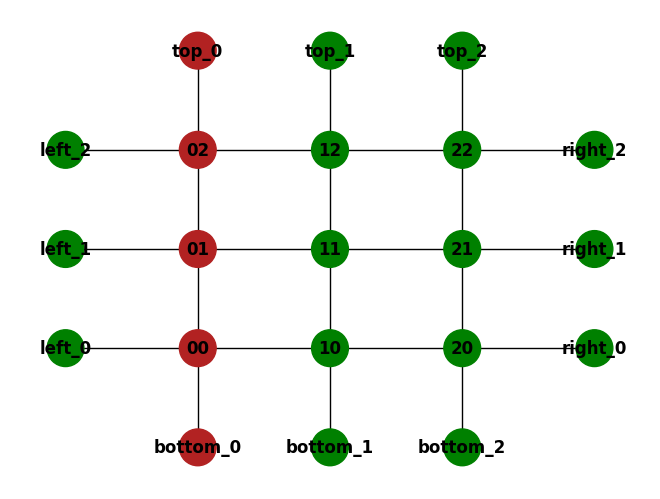

Entanglement generated between qubits 0 and 1
Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
TIME: 2


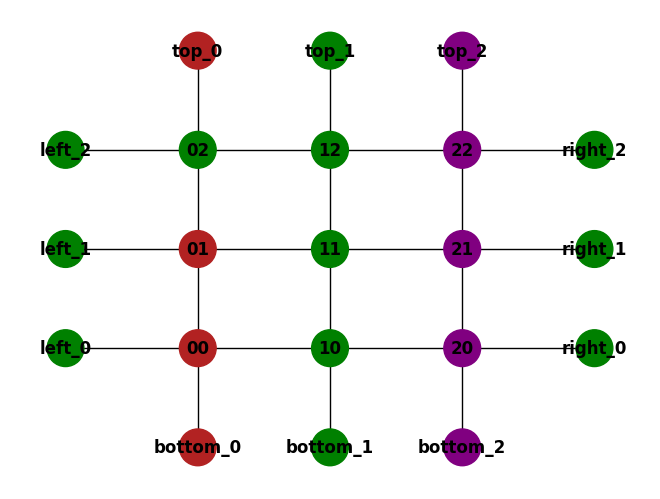

Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
Entanglement generated between qubits 4 and 5
BSM performed on 3 and 4
TIME: 3


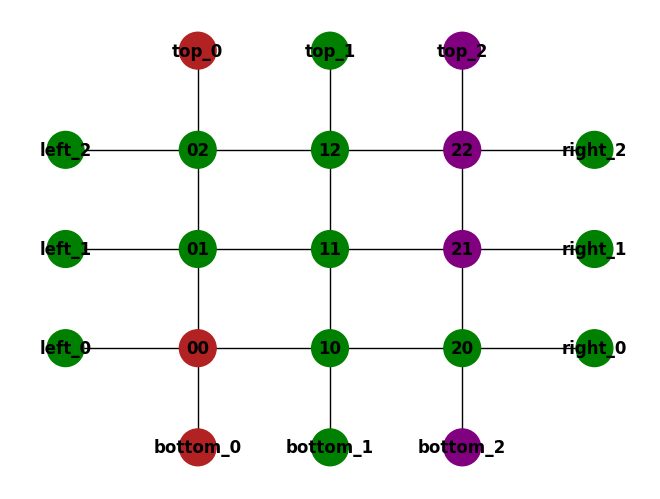

Entanglement generated between qubits 4 and 5
BSM performed on 3 and 4
Entanglement generated between qubits 6 and 7
BSM performed on 5 and 6
TIME: 4


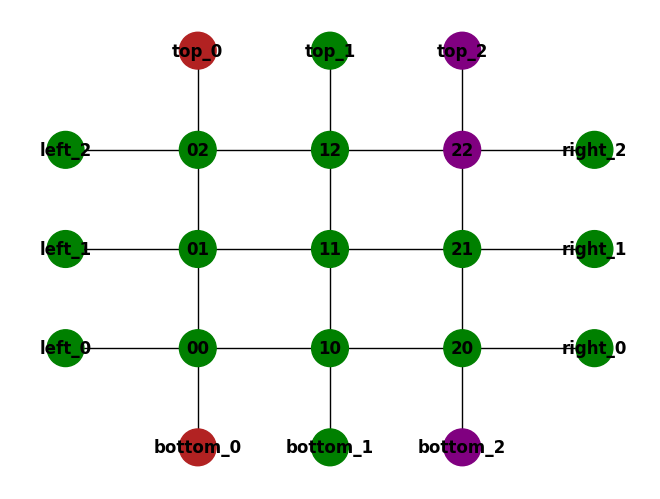

Entanglement generated between qubits 0 and 1
Photon lost, link not generated between 3 and 4
FINAL BELL STATE: [[0.5       +0.j 0.        +0.j 0.        +0.j 0.49850225+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.49850225+0.j 0.        +0.j 0.        +0.j 0.5       +0.j]]
TIME: 5


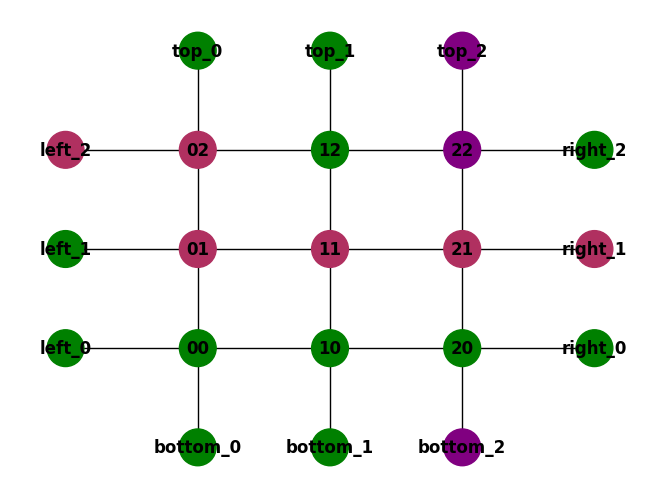

Photon lost, link not generated between 1 and 2
Photon lost, link not generated between 3 and 4
TIME: 6


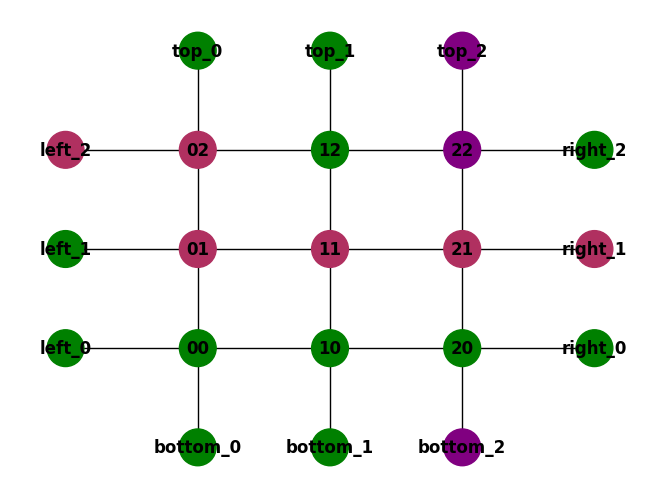

Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
Entanglement generated between qubits 6 and 7
BSM performed on 5 and 6
TIME: 7


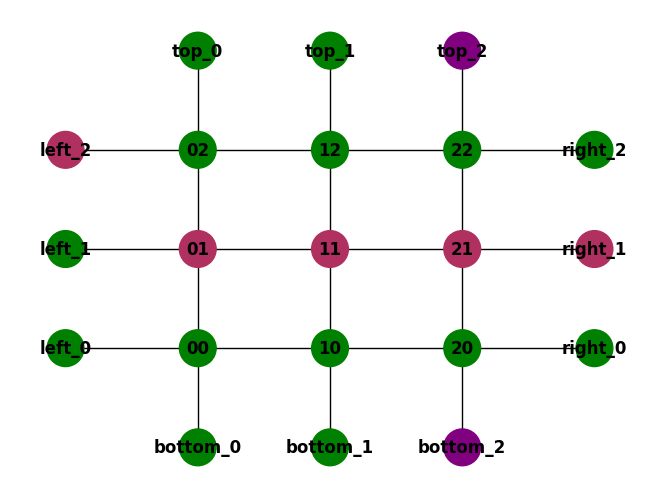

Entanglement generated between qubits 4 and 5
BSM performed on 3 and 4
FINAL BELL STATE: [[0.5       +0.j 0.        +0.j 0.        +0.j 0.49800399+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.49800399+0.j 0.        +0.j 0.        +0.j 0.5       +0.j]]
TIME: 8


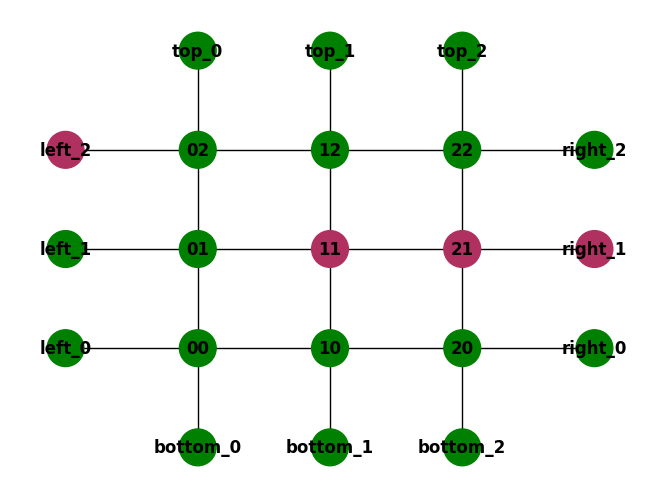

Entanglement generated between qubits 6 and 7
BSM performed on 5 and 6
TIME: 9


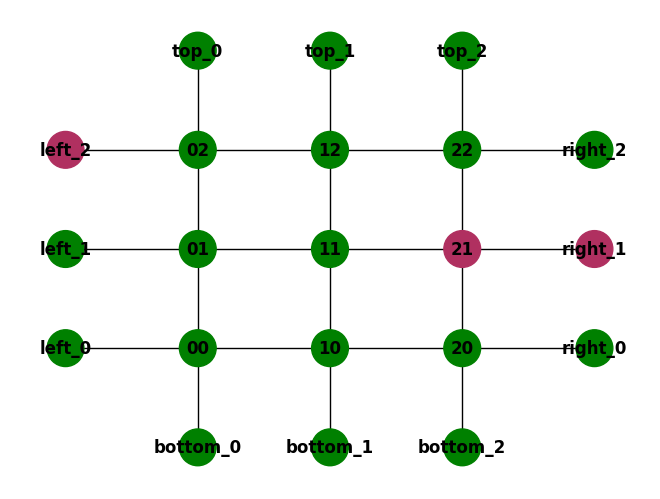

Entanglement generated between qubits 8 and 9
BSM performed on 7 and 8
TIME: 10


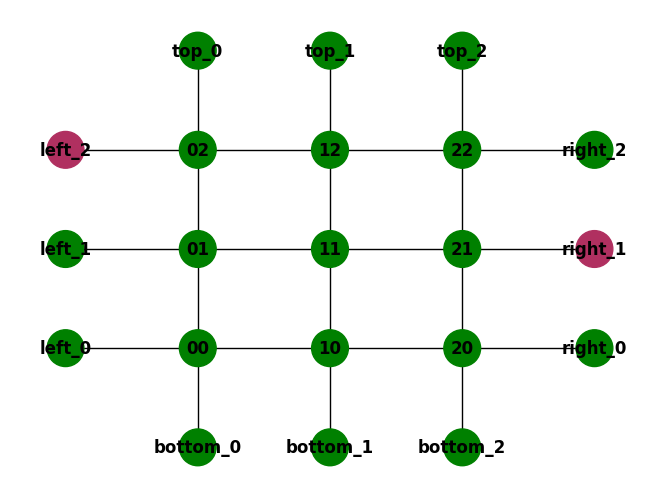

FINAL BELL STATE: [[0.5       +0.j 0.        +0.j 0.        +0.j 0.49781728+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.49781728+0.j 0.        +0.j 0.        +0.j 0.5       +0.j]]
TIME: 11


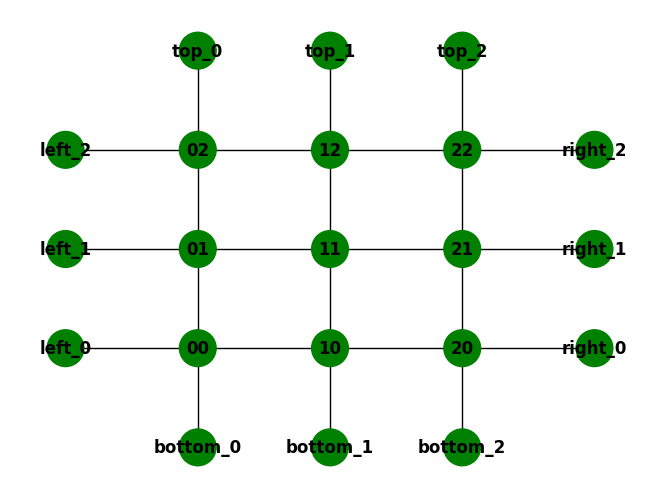

TIME: 12


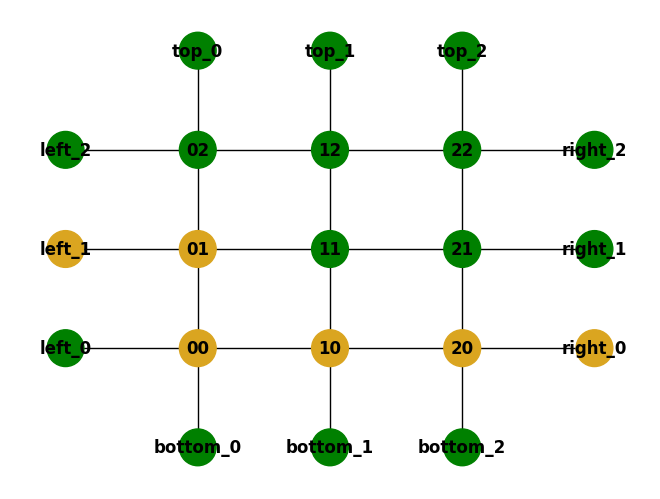

Entanglement generated between qubits 0 and 1
Entanglement generated between qubits 0 and 1
TIME: 13


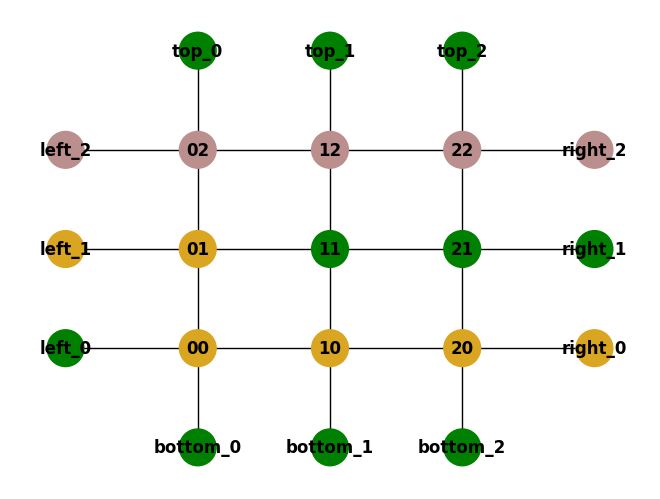

Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
TIME: 14


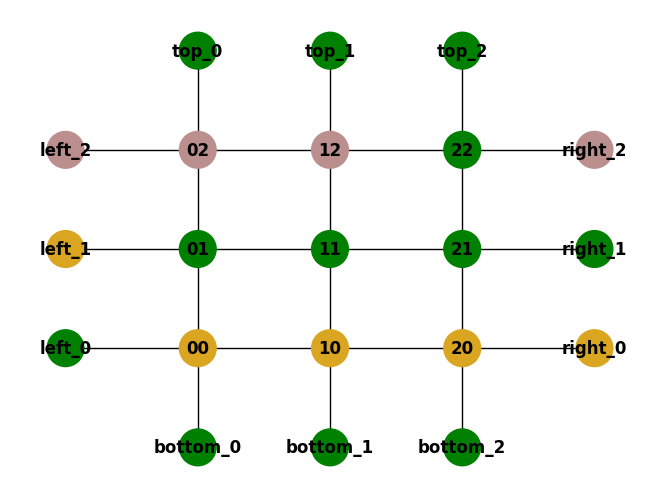

Entanglement generated between qubits 0 and 1
TIME: 1


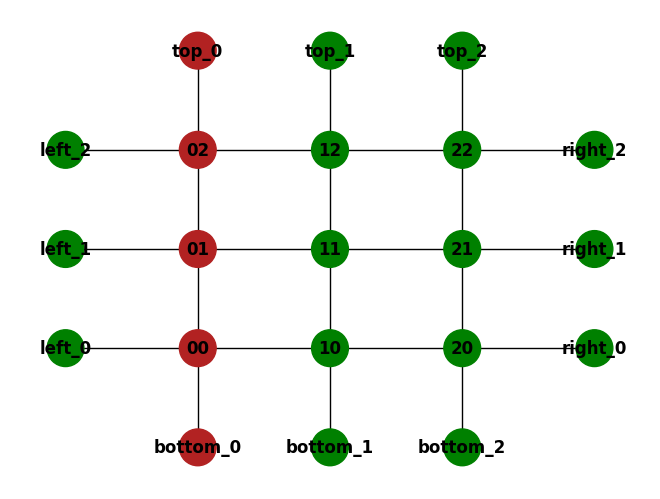

Entanglement generated between qubits 0 and 1
Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
TIME: 2


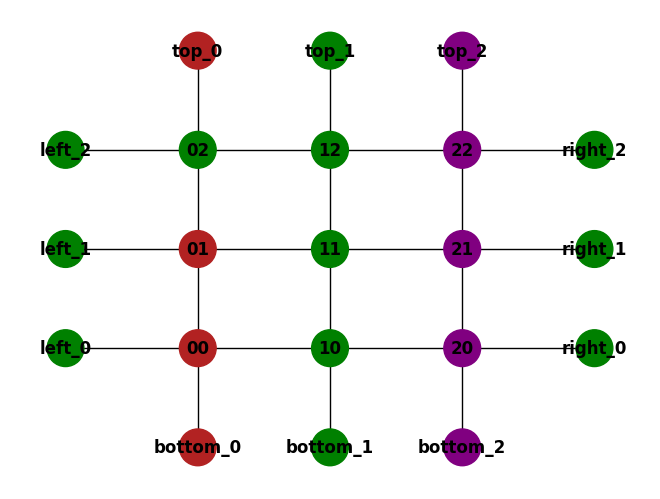

Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
Entanglement generated between qubits 4 and 5
BSM performed on 3 and 4
TIME: 3


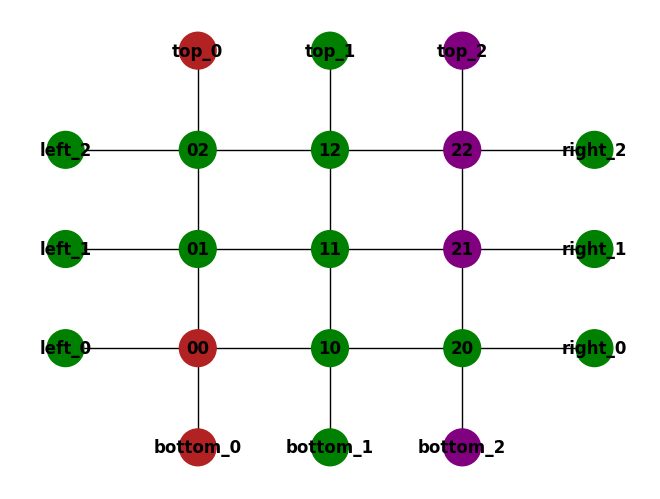

Entanglement generated between qubits 4 and 5
BSM performed on 3 and 4
Entanglement generated between qubits 6 and 7
BSM performed on 5 and 6
TIME: 4


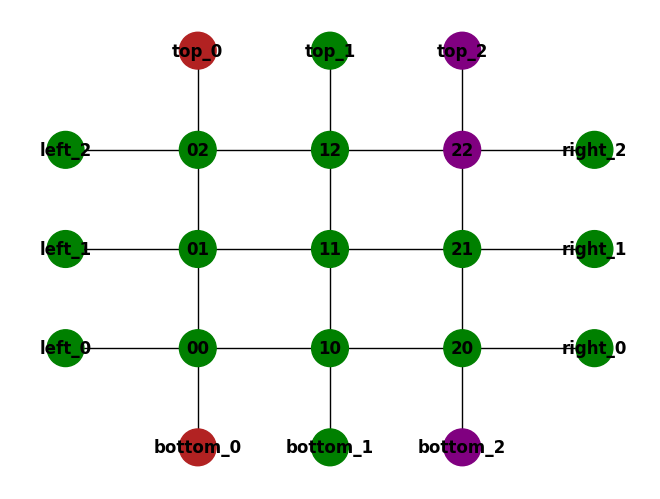

Entanglement generated between qubits 0 and 1
Photon lost, link not generated between 3 and 4
FINAL BELL STATE: [[0.5     +0.j 0.      +0.j 0.      +0.j 0.499001+0.j]
 [0.      +0.j 0.      +0.j 0.      +0.j 0.      +0.j]
 [0.      +0.j 0.      +0.j 0.      +0.j 0.      +0.j]
 [0.499001+0.j 0.      +0.j 0.      +0.j 0.5     +0.j]]
TIME: 5


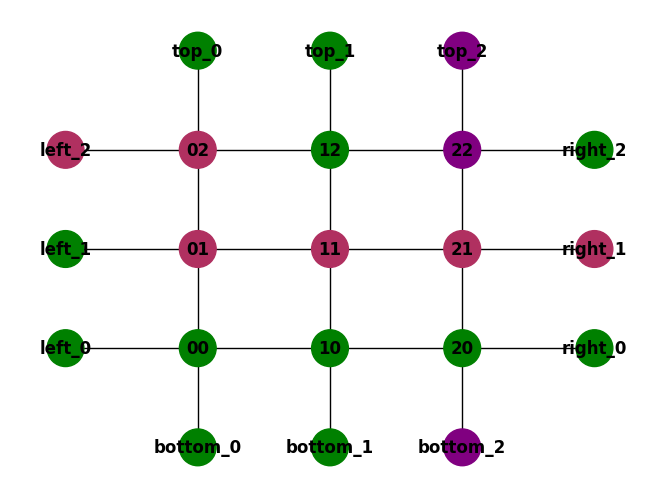

Photon lost, link not generated between 1 and 2
Photon lost, link not generated between 3 and 4
TIME: 6


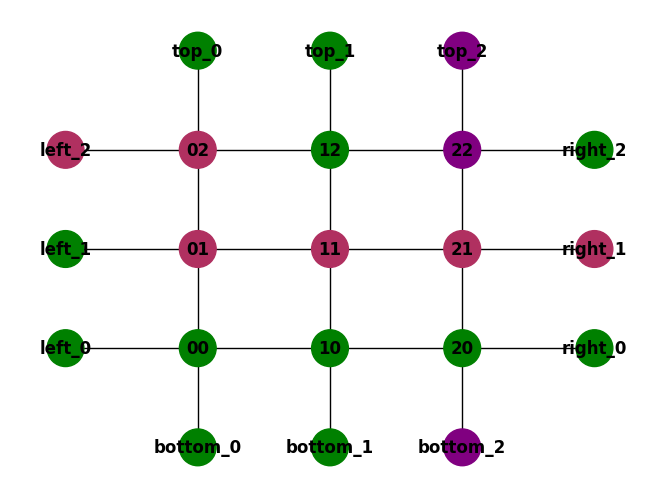

Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
Entanglement generated between qubits 6 and 7
BSM performed on 5 and 6
TIME: 7


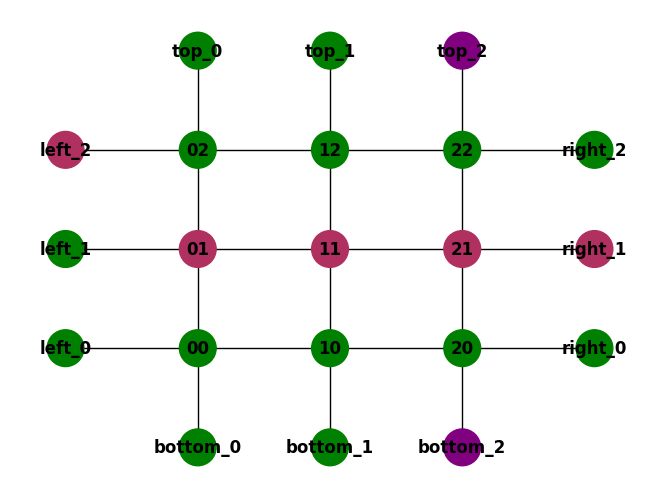

Entanglement generated between qubits 4 and 5
BSM performed on 3 and 4
FINAL BELL STATE: [[0.5       +0.j 0.        +0.j 0.        +0.j 0.49866844+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.49866844+0.j 0.        +0.j 0.        +0.j 0.5       +0.j]]
TIME: 8


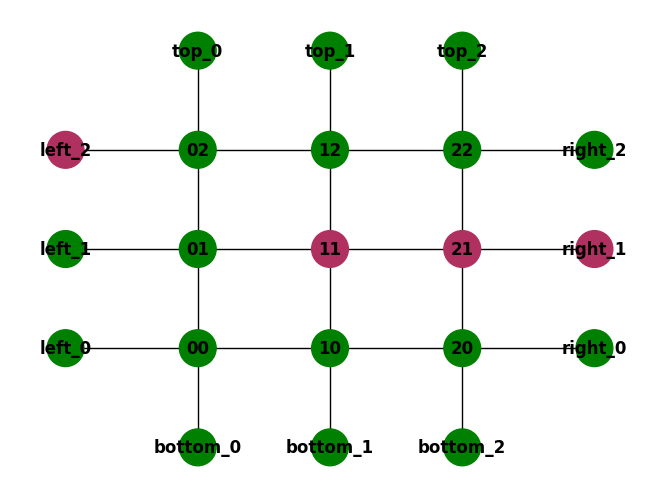

Entanglement generated between qubits 6 and 7
BSM performed on 5 and 6
TIME: 9


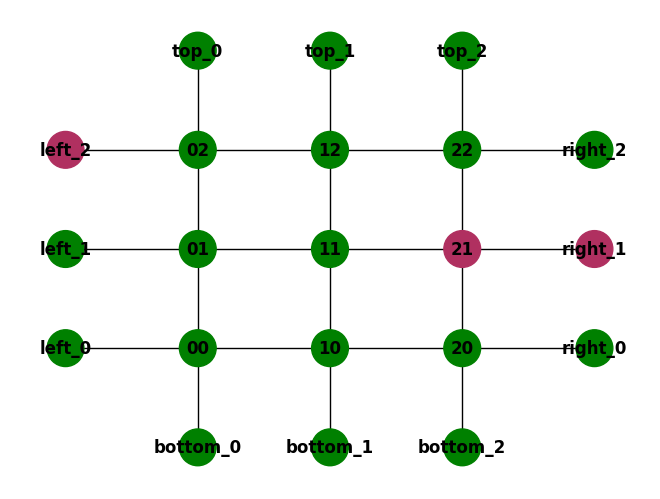

Entanglement generated between qubits 8 and 9
BSM performed on 7 and 8
TIME: 10


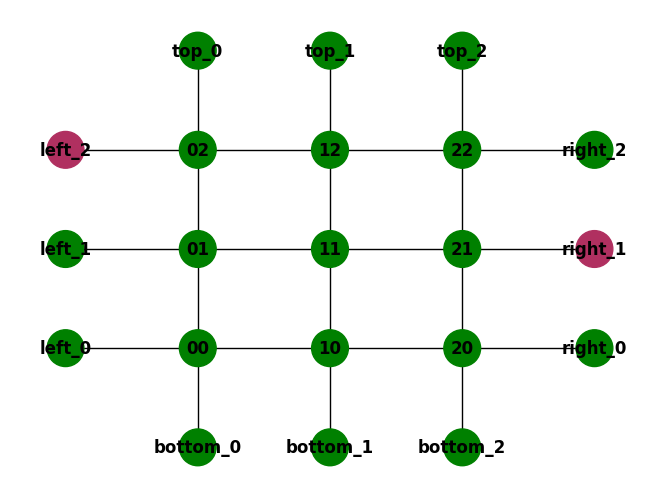

FINAL BELL STATE: [[0.5       +0.j 0.        +0.j 0.        +0.j 0.49854379+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.49854379+0.j 0.        +0.j 0.        +0.j 0.5       +0.j]]
TIME: 11


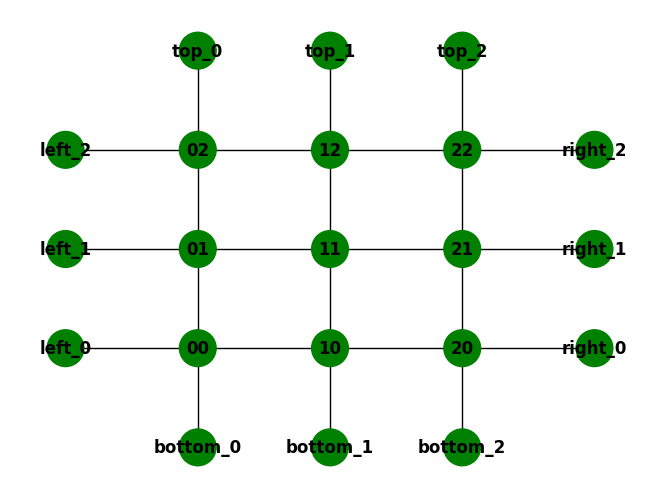

TIME: 12


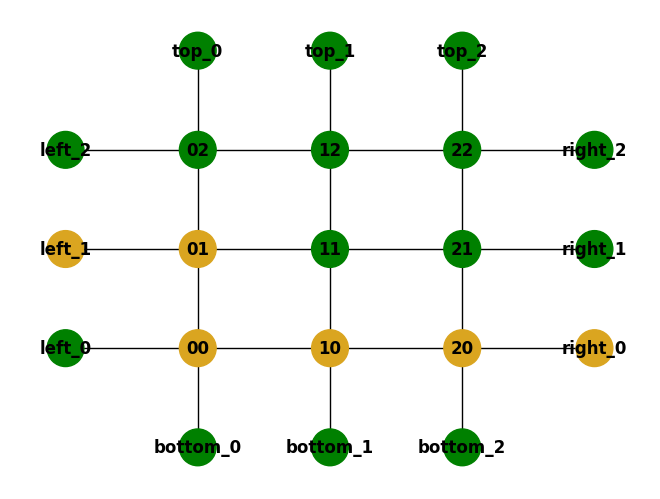

Entanglement generated between qubits 0 and 1
Entanglement generated between qubits 0 and 1
TIME: 13


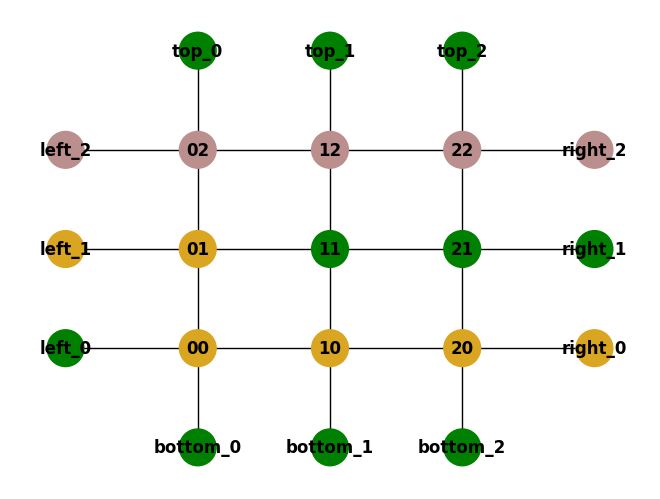

Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
TIME: 14


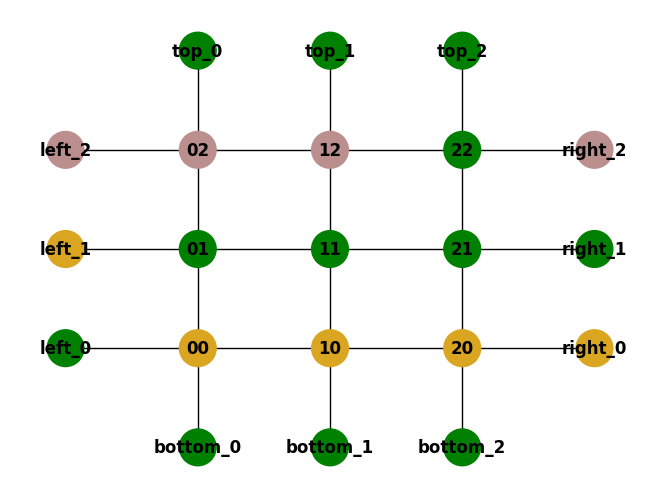

Entanglement generated between qubits 0 and 1
TIME: 1


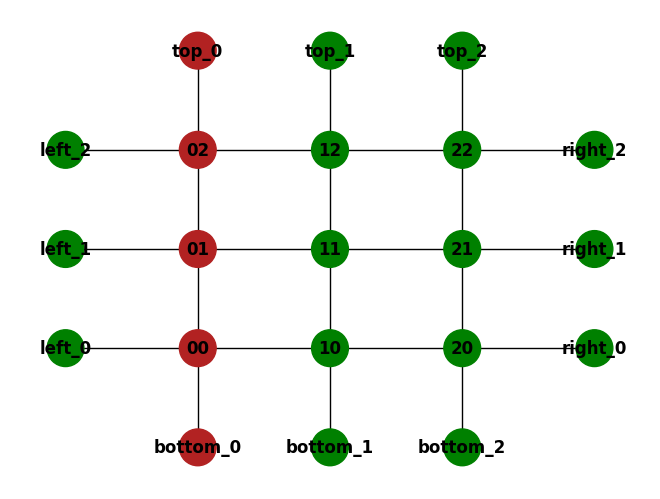

Entanglement generated between qubits 0 and 1
Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
TIME: 2


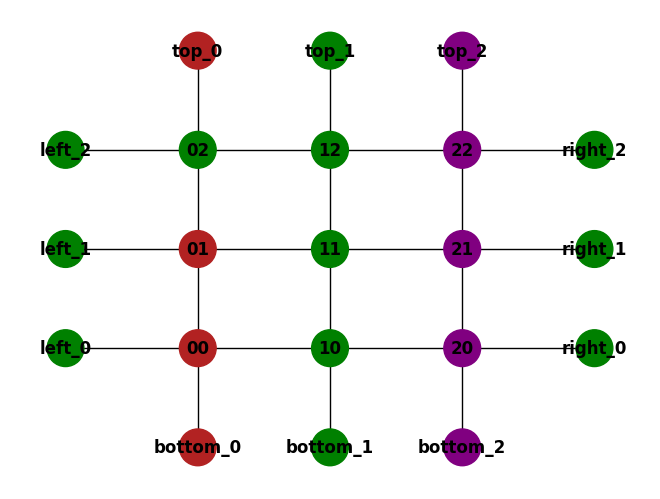

Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
Entanglement generated between qubits 4 and 5
BSM performed on 3 and 4
TIME: 3


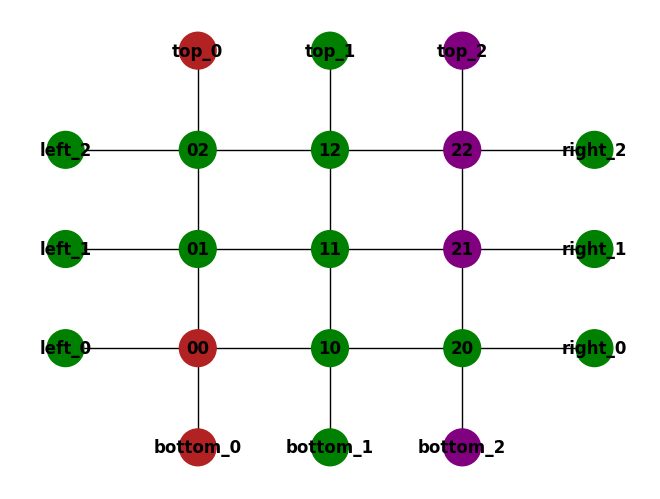

Entanglement generated between qubits 4 and 5
BSM performed on 3 and 4
Entanglement generated between qubits 6 and 7
BSM performed on 5 and 6
TIME: 4


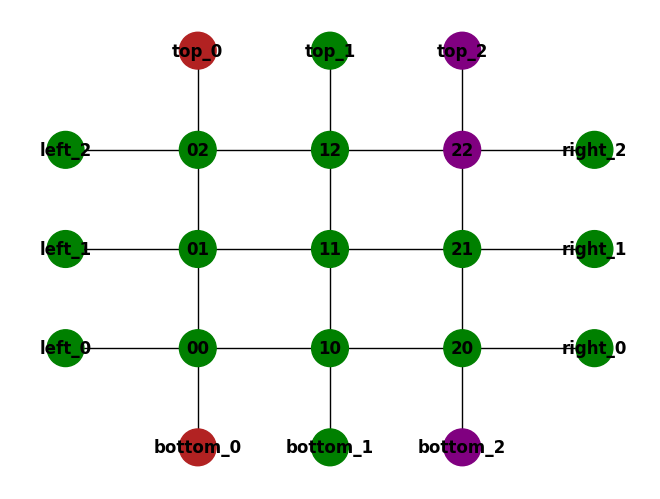

Entanglement generated between qubits 0 and 1
Photon lost, link not generated between 3 and 4
FINAL BELL STATE: [[0.5       +0.j 0.        +0.j 0.        +0.j 0.49985002+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.49985002+0.j 0.        +0.j 0.        +0.j 0.5       +0.j]]
TIME: 5


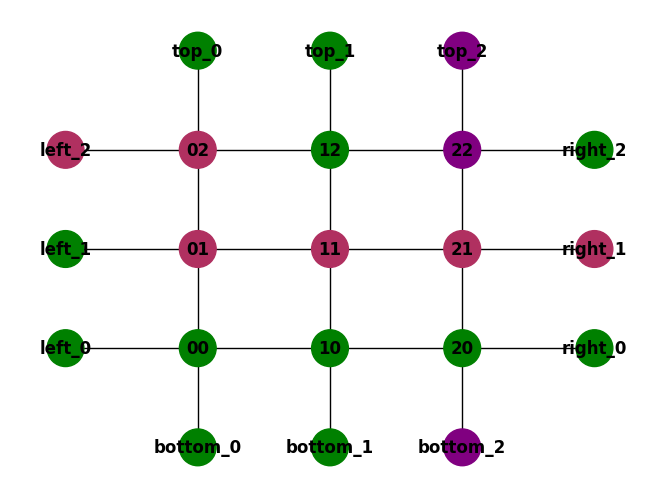

Photon lost, link not generated between 1 and 2
Photon lost, link not generated between 3 and 4
TIME: 6


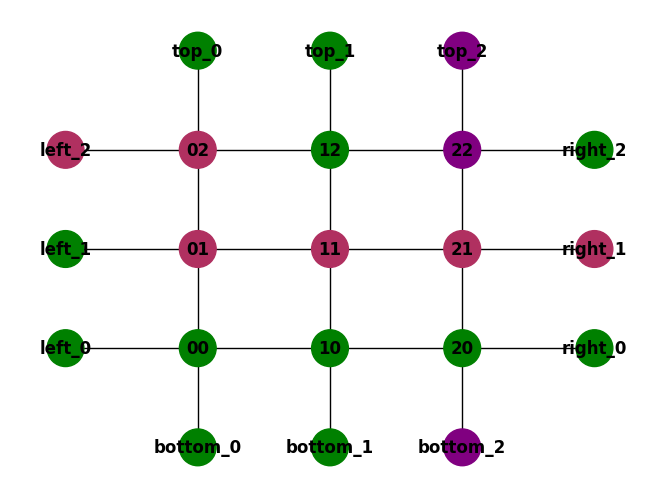

Entanglement generated between qubits 2 and 3
BSM performed on 1 and 2
Entanglement generated between qubits 6 and 7
BSM performed on 5 and 6
TIME: 7


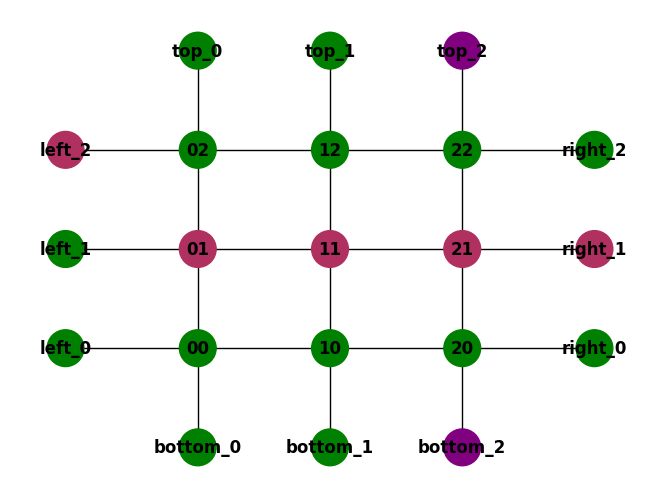

Entanglement generated between qubits 4 and 5
BSM performed on 3 and 4
FINAL BELL STATE: [[0.5       +0.j 0.        +0.j 0.        +0.j 0.49980004+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.49980004+0.j 0.        +0.j 0.        +0.j 0.5       +0.j]]
TIME: 8


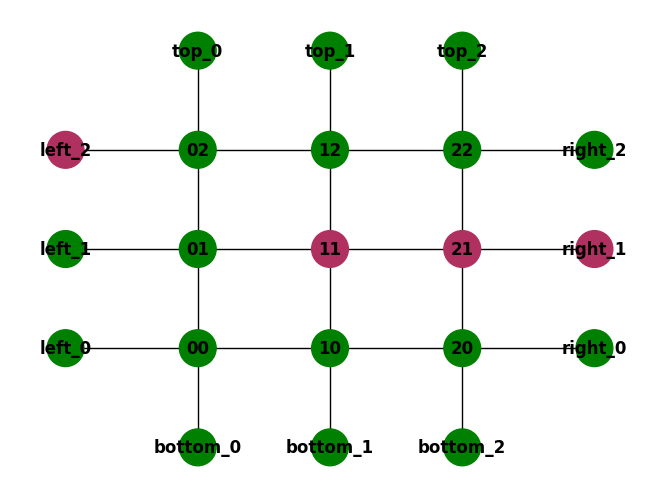

Entanglement generated between qubits 6 and 7
BSM performed on 5 and 6
TIME: 9


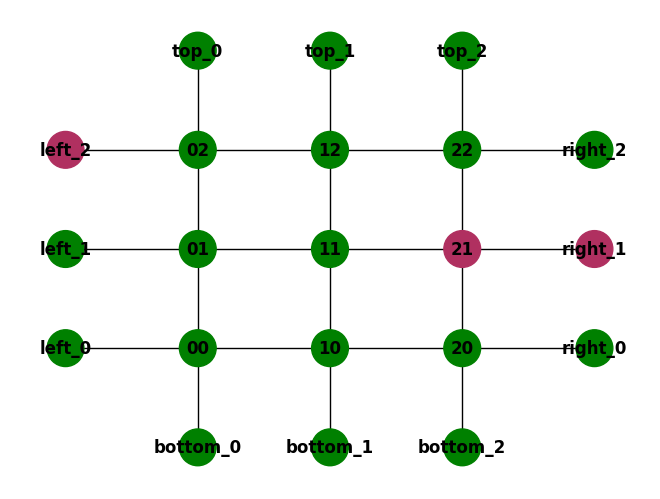

Entanglement generated between qubits 8 and 9
BSM performed on 7 and 8
TIME: 10


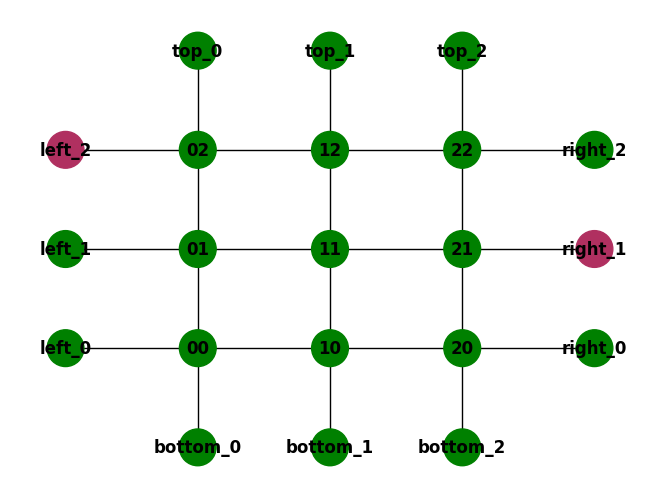

FINAL BELL STATE: [[0.5      +0.j 0.       +0.j 0.       +0.j 0.4997813+0.j]
 [0.       +0.j 0.       +0.j 0.       +0.j 0.       +0.j]
 [0.       +0.j 0.       +0.j 0.       +0.j 0.       +0.j]
 [0.4997813+0.j 0.       +0.j 0.       +0.j 0.5      +0.j]]
TIME: 11


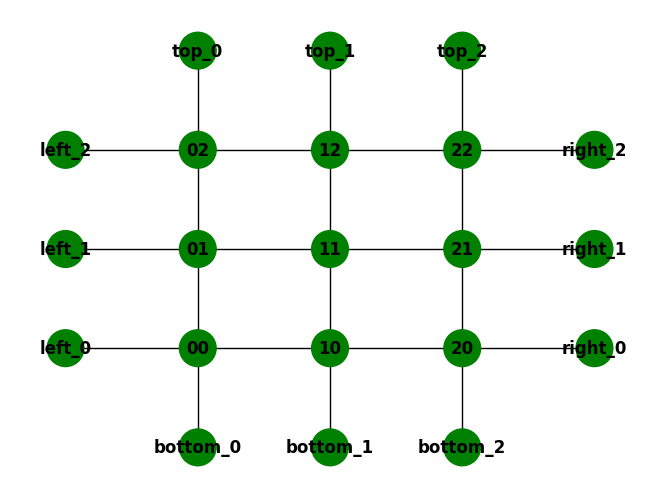

TIME: 12


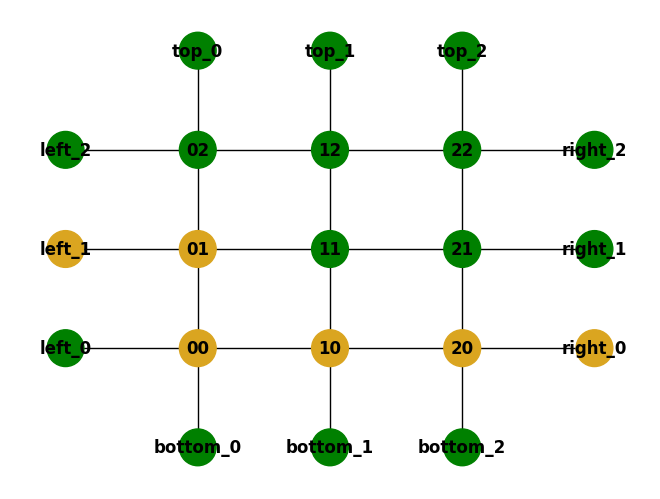

Entanglement generated between qubits 0 and 1


In [ ]:
fidelities_dict = {}


T_dp_list = [10, 15, 100]
for time in T_dp_list:
    T_dp = time
    # Main execution
    grid_size = 3
    random.seed(2)
    fidelities = []
    simulation_time = 15

    # Create the simulation environment
    env = simpy.Environment()

    # Create and connect the grid network
    grid = CustomGrid(grid_size, env)

    # Generate different shades of red for communications
    shades_of_red = ["#B22222", "#800080", "#B03060", "#DAA520", "#BC8F8F"]

    # List to store communication attempts
    communication_queue = []

    # Start the communication manager
    env.process(communication_manager(env, grid, communication_queue, shades_of_red, T_dp, d))

    # Generate communication attempts from edge nodes
    env.process(generate_communications(env, grid, communication_queue))

    # Start the plot manager
    env.process(plot_manager(env, grid, shades_of_red))

    # Run the simulation
    env.run(until=simulation_time)  # Run the simulation for 15 time steps

    rate = len(fidelities)/simulation_time
    avg_fidelity = np.mean(fidelities)

    fidelities_dict[f"Dephasing time: {T_dp}"] = (rate, avg_fidelity)


In [ ]:
print(fidelities)
rate = len(fidelities)/simulation_time
avg_fidelity = np.mean(fidelities)



# Testing out partial tracing

In [ ]:

def entanglement_generation(rho: Qobj, target_qubits: list, num_qubits: int, n: int, P_link: float, T_p: float, eta_eff: float, F_initial=0.7):
    """
    NOTE: q1 must be greater than q0
    """
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    rho = perfect_phi_plus_gen(rho, num_qubits_left, num_qubits_right, F_initial, num_qubits)

    # dephasing on q0
    rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=num_qubits_left, right_padding=num_qubits_right + 1, num_qubits=num_qubits)

    # dephasing on q1
    rho = dephasing_channel(rho=rho, t=d / c, left_padding=num_qubits_left + 1, right_padding=num_qubits_right, num_qubits=num_qubits)


    if q0 > 1:
        # dephasing on left of q0
        rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=num_qubits_left - 1, right_padding=num_qubits_right + 2, num_qubits=num_qubits)

        # dephasing on first qubit
        rho = dephasing_channel(rho=rho, t=2 * d / c, left_padding=0, right_padding=num_qubits - 1, num_qubits=num_qubits)


    #rho = dark_counts(rho_initial=rho, target=q1, P_link=P_link, num_qubits=num_qubits)

    return rho

def entanglement_swapping(rho: Qobj, target_qubits: list, num_qubits: int, lambda_BSM=1):
    q0, q1 = target_qubits[0], target_qubits[1]
    num_qubits_left = q0
    num_qubits_right = (num_qubits - 1) - q1

    bell_measure_op = pad_op(phi_plus_rho, left_padding = num_qubits_left, right_padding = num_qubits_right, num_qubits=num_qubits)
    rho = (bell_measure_op * rho * bell_measure_op.dag()).unit()

    # adding bell state measurement error
    #rho = lambda_BSM * rho + (1 - lambda_BSM) / 4 * tensor(I(), I())
    return rho



num_qubits = 8
rho = initial_rho(num_qubits)
rho = entanglement_generation(rho=rho, target_qubits=[0,1], num_qubits=num_qubits)
rho = entanglement_generation(rho = rho, target_qubits=[2,3], num_qubits=num_qubits)

# PRINTING OUT PARTIAL TRACE OF ALL QUBITS
print('PARTIAL TRACE B4')
print("Q0Q1\n", rho.ptrace([0,1]).full())
print("Q2Q3\n", rho.ptrace([2,3]).full())
rho = entanglement_swapping(rho = rho , target_qubits = [1,2], num_qubits=num_qubits)

# PRINTING OUT PARTIAL TRACE OF ALL QUBITS
print('PARTIAL AFTER')
print("Q0Q3\n", rho.ptrace([0,3]).full())



In [ ]:
BSM_qubits = [i for i in range(10)]
length = len(BSM_qubits)
measured_qubits = []
j = 0
while j < length-2: # bell state measurements up until last qubit
  print (j)
  removed_element = BSM_qubits.pop(j)
  measured_qubits.append(removed_element)
  j += 2


In [ ]:
BSM_qubits = [i for i in range(10)]
measured_qubits = []

while BSM_qubits:
    # Measure qubits at even indices in the current list
    for j in range(0, len(BSM_qubits), 2):
        measured_qubits.append(BSM_qubits[j])

    # Remove the measured qubits from BSM_qubits
    BSM_qubits = [q for q in BSM_qubits if q not in measured_qubits]

    print("Measured qubits:", measured_qubits)
    print("Remaining BSM_qubits:", BSM_qubits)

print("Final Measured qubits:", measured_qubits)
